In [1]:
import sys
sys.path.append("/home/federico/programming/CM/")
# sys.path.append("/home/federico/Desktop/University/CM/")


from Network import NR, NC
import utils as utils
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from matplotlib import pyplot as plt

In [2]:
def plot_MONK_stats(conf, dataset, test, X_train, y_train, X_test, y_test, save=False, time=True):
    print(conf[dataset][test])
    
    if dataset == 'cup':
        net = NR(**conf[dataset][test])
    else:
        net = NC(**conf[dataset][test])

    net.fit(X_train, y_train, test_data=(X_test, y_test))
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=time)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=time)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())

In [3]:
def report_plots(dataset, net_SGD, net_SGD_nest, net_SGM, score=False):
    
    sgd_loss = net_SGD.train_loss
    sgd_nest_loss = net_SGD_nest.train_loss
    sgm_loss = net_SGM.train_loss

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_SGM = net_SGM.train_scores if score else net_SGM.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_SGM_time = net_SGM.epochs_time
    x_SGM_ep = list(range(len(train_res_SGM)))
    
    
    print("----- SGD -----")
    print(params[dataset]['SGD'])
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(params[dataset]['SGD'])
    print(net_SGD_nest.best_score(),"\n")

    print("----- SGM -----")
    print(params[dataset]['SGM'])
    print(net_SGM.best_score(),"\n")

    # Plots losses w.r.t. time
    plt.semilogy(x_SGD_time, train_res_SGD, '--', label='SGD CM')
    plt.semilogy(x_SGD_nest_time, train_res_SGD_nest, '--', label='SGD NAG')
    plt.semilogy(x_SGM_time, train_res_SGM, '--', label='SGM')
    plt.xlabel(x_label_time)
    plt.ylabel ('Loss')
    plt.legend(loc='best')
    plt.title (f'Loss NN {dataset} dataset')
    plt.show()
    plt.clf()

    # Plots losses w.r.t. epochs
    plt.semilogy(x_SGD_ep, train_res_SGD, '--', label='SGD CM')
    plt.semilogy(x_SGD_nest_ep, train_res_SGD_nest, '--', label='SGD NAG')
    plt.semilogy(x_SGM_ep, train_res_SGM, '--', label='Loss SGM')
    plt.xlabel(x_label_ep)
    plt.ylabel ('Loss')
    plt.legend(loc='best')
    plt.title (f'Loss NN {dataset} dataset')
    plt.show()
    plt.clf()

    # Plots gradient norms
    plt.semilogy(x_SGD_ep, net_SGD.grad_est_per_epoch, '--', label='SGD CM')
    plt.semilogy(x_SGD_nest_ep, net_SGD_nest.grad_est_per_epoch, '--', label='SGD NAG')
    plt.semilogy(x_SGM_ep, net_SGM.grad_est_per_epoch, '--', label='SGM')

    plt.xlabel(x_label_ep)
    plt.ylabel ('Gradient Norm')

    plt.legend(loc='best')
    plt.title (f'Gradient norms for both SGD and SGM over {dataset}')

    plt.show()
    plt.clf()

In [4]:
def report_stats(dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC

    # Plots together results from SGD and SGM
    param_SGD = params[dataset]['SGD'].copy()
    param_SGD_nest = params[dataset]['SGD'].copy()
    param_SGM = params[dataset]['SGM'].copy()
    
    param_SGD['debug'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['debug'] = debug
    param_SGD_nest['nesterov'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_SGM['debug'] = debug
    net_SGM = nn(**param_SGM)    

    net_SGD.fit(X_train, y_train)
    net_SGD_nest.fit(X_train, y_train)
    net_SGM.fit(X_train, y_train)

    return net_SGD, net_SGD_nest, net_SGM

In [5]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}


# TODO: aggiungere json di configurazione
params = {
    'cup': {
        'SGD': {
            'batch_size': 32,
            'epochs': 1000,
            'eps': 1e-6,
            'eta': 0.001,
            'lmbda': 0.001,
            'momentum': 0.,
            'optimizer': "SGD",
            'sizes': [30, 50],
            'activation': 'Lrelu',
            'debug': True,
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 1000,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.001,
            'optimizer': "SGM",
            'sizes': [30, 50],
            'activation': 'Lrelu',
            'debug': True,
        }
    },
    'monk1': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': 32,
            'epochs': 500,
            'eps': 1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 1000,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True
        }
    },
    'monk2': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': 32,
            'epochs': 500,
            'eps': 1e-6,
            'eta': 0.01,
            'lmbda': 0.01,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [3],
            'debug': True
        },
        'SGM': {
            'batch_size': 10,
            'epochs': 500,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.001,
            'optimizer': "SGM",
            'sizes': [3],
            'debug': True,
        }
    },
    'monk3': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': 10,
            'epochs': 500,
            'eps': 1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 1000,
            'eps':1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True,
        }
    }
}

## Testing configuration

In [23]:
test = "SGM"
dataset = "cup"

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
net = nn(**params[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 4.04619e+02 || Loss: 2.13172e+01, 2.18771e+01 || Score: 0.713, 0.719
2       || Gradient norm: 3.13035e+02 || Loss: 1.58792e+01, 1.60508e+01 || Score: 0.782, 0.788
3       || Gradient norm: 2.80334e+02 || Loss: 1.27860e+01, 1.28630e+01 || Score: 0.822, 0.828
4       || Gradient norm: 2.67308e+02 || Loss: 1.06986e+01, 1.06825e+01 || Score:  0.85, 0.855
5       || Gradient norm: 2.76201e+02 || Loss: 9.31119e+00, 9.20297e+00 || Score: 0.868, 0.874
6       || Gradient norm: 2.96032e+02 || Loss: 8.28503e+00, 8.12655e+00 || Score: 0.882, 0.888
7       || Gradient norm: 2.92884e+02 || Loss: 7.53115e+00, 7.31296e+00 || Score: 0.892, 0.898
8       || Gradient norm: 2.93366e+02 || Loss: 6.99429e+00, 6.69697e+00 || Score: 0.899, 0.906
9       || Gradient norm: 2.91379e+02 || Loss: 6.58153e+00, 6.23599e+00 || Score: 0.904, 0.913
10      || Gradient norm: 2.91818e+02 || Loss: 6.27087e+00, 5.87927e+00 || Score: 0.909, 0.918
11      || Gradient norm: 2.92992e+02 || Loss: 6.0

NR(batch_size=32, debug=True, eps=1e-06, eta=0.1, lmbda=0.001, optimizer='SGM',
   sizes=[30, 50])

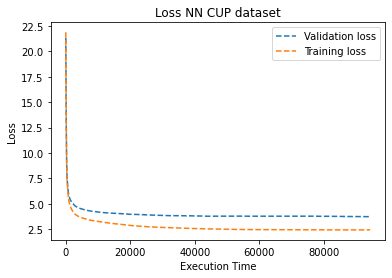

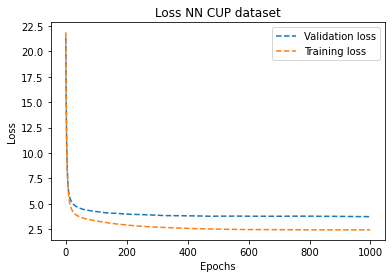

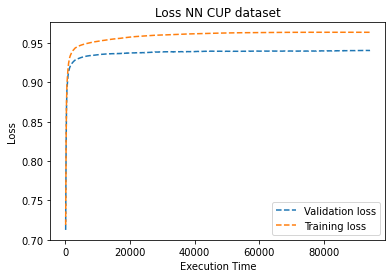

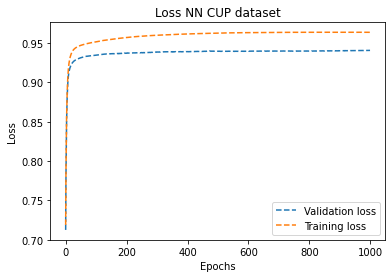

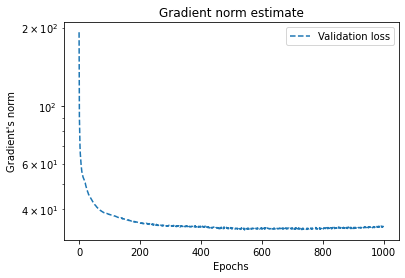

ep: 1000    | s: [] | b: 32 | e:  0.1 | lmbda:0.001 | m:  0.0
Grad: 1.81346e+02 | Loss: 3.74531e+00, 2.45059e+00 | Score: 0.941, 0.964
ended in: 94289.474, avg per ep: 94.289474
total update: 71.475, avg updt: 0.071475
total ff: 41000, total ff time: 33361.35399999938, avg ff: 0.8136915609755947
total bp: 39000, total bp time: 39865.914000000506, avg bp: 1.022202923076936
total ev: 1000, total ev time: 25938.773999999994, avg ev: 25.938773999999995




<Figure size 432x288 with 0 Axes>

In [24]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

# Test convergence to 1e-4

In [6]:
# TODO: aggiungere json di configurazione
params_conv = {
    'cup': {
        'SGD': {
            'batch_size': None,
            'epochs': 10000,
            'eps': 1e-2,
            'eta': 0.005,
            'lmbda': 0.001,
            'momentum': 0.5,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [30, 50],
            'activation': 'Lrelu',
            'debug': True,
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 10000,
            'eps':1e-2,
            'eta': 0.1,
            'lmbda': 0.001,
            'optimizer': "SGM",
            'sizes': [30, 50],
            'activation': 'Lrelu',
            'debug': True,
        }
    },
    'monk1': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': None,
            'epochs': 10000,
            'eps': 1e-3,
            'eta': 0.1,
            'lmbda': 0.,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 10000,
            'eps':1e-3,
            'eta': 0.1,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True
        }
    },
    'monk2': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': None,
            'epochs': 10000,
            'eps': 1e-3,
            'eta': 0.1,
            'lmbda': 0.,
            'momentum': 0.5,
            'optimizer': "SGD",
            'sizes': [3],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 10000,
            'eps':1e-3,
            'eta': 0.01,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [3],
            'debug': True,
        }
    },
    'monk3': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': None,
            'epochs': 10000,
            'eps': 1e-3,
            'eta': 0.01,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 10000,
            'eps':1e-3,
            'eta': 0.01,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True,
        }
    }
}

## SGD

In [59]:
test = "SGD"
dataset = "monk1"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 9.99730e-02 || Loss: 1.40038e-01, 1.41525e-01 || Score: 0.523, 0.508
2       || Gradient norm: 9.85585e-02 || Loss: 1.39030e-01, 1.40223e-01 || Score: 0.523, 0.516
3       || Gradient norm: 9.60754e-02 || Loss: 1.37918e-01, 1.38766e-01 || Score:  0.53, 0.516
4       || Gradient norm: 9.23596e-02 || Loss: 1.36796e-01, 1.37279e-01 || Score: 0.523, 0.516
5       || Gradient norm: 8.90273e-02 || Loss: 1.35710e-01, 1.35818e-01 || Score: 0.523, 0.524
6       || Gradient norm: 8.68607e-02 || Loss: 1.34670e-01, 1.34398e-01 || Score: 0.532, 0.548
7       || Gradient norm: 8.36124e-02 || Loss: 1.33690e-01, 1.33056e-01 || Score: 0.535, 0.548
8       || Gradient norm: 7.85166e-02 || Loss: 1.32786e-01, 1.31833e-01 || Score: 0.528, 0.54 
9       || Gradient norm: 7.54027e-02 || Loss: 1.31953e-01, 1.30700e-01 || Score: 0.532, 0.532
10      || Gradient norm: 7.21225e-02 || Loss: 1.31184e-01, 1.29650e-01 || Score:  0.53, 0.532
11      || Gradient norm: 6.95083e-02 || Loss: 1.3

NC(batch_size=124, debug=True, epochs=10000, eps=0.001, lmbda=0.0, sizes=[5])

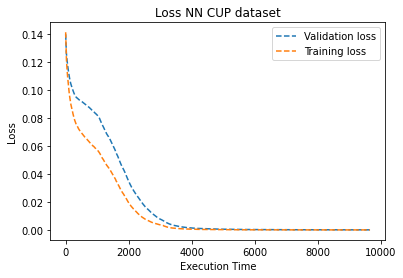

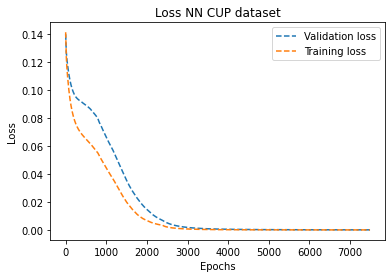

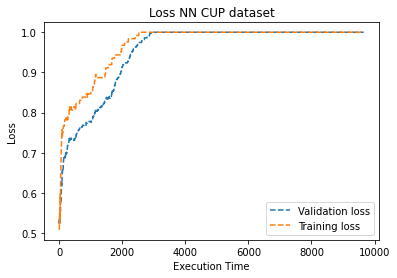

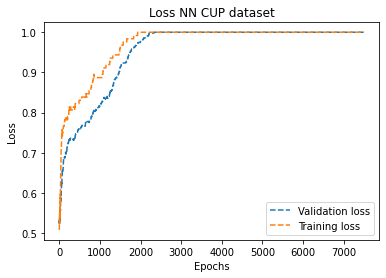

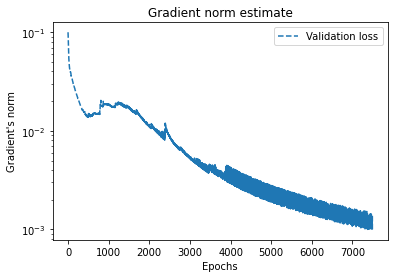

ep: 10000   | s: [5] | b: 124 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.89372e-04 | Loss: 5.91096e-05, 1.38921e-05 | Score:     1, 1    
ended in: 9656.086, avg per ep: 0.9656085999999999
total update: 0.316, avg updt: 3.16e-05
total ff: 22473, total ff time: 3928.2760000000108, avg ff: 0.1747998042094963
total bp: 7491, total bp time: 1425.9509999999939, avg bp: 0.190355226271525
total ev: 7491, total ev time: 4776.307000000002, avg ev: 0.6376060606060608




<Figure size 432x288 with 0 Axes>

In [60]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [61]:
test = "SGD"
dataset = "monk2"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 4.50686e-02 || Loss: 1.26277e-01, 1.29678e-01 || Score: 0.507, 0.456
2       || Gradient norm: 4.45160e-02 || Loss: 1.25881e-01, 1.29363e-01 || Score: 0.505, 0.456
3       || Gradient norm: 4.40755e-02 || Loss: 1.25431e-01, 1.29002e-01 || Score: 0.514, 0.473
4       || Gradient norm: 4.30647e-02 || Loss: 1.24968e-01, 1.28633e-01 || Score: 0.519, 0.485
5       || Gradient norm: 4.21730e-02 || Loss: 1.24505e-01, 1.28261e-01 || Score: 0.523, 0.479
6       || Gradient norm: 4.21423e-02 || Loss: 1.24050e-01, 1.27894e-01 || Score: 0.521, 0.479
7       || Gradient norm: 4.08501e-02 || Loss: 1.23613e-01, 1.27544e-01 || Score:  0.53, 0.485
8       || Gradient norm: 3.90789e-02 || Loss: 1.23199e-01, 1.27214e-01 || Score: 0.532, 0.497
9       || Gradient norm: 3.82013e-02 || Loss: 1.22804e-01, 1.26900e-01 || Score: 0.535, 0.503
10      || Gradient norm: 3.74602e-02 || Loss: 1.22427e-01, 1.26603e-01 || Score: 0.544, 0.521
11      || Gradient norm: 3.50913e-02 || Loss: 1.2

NC(batch_size=169, debug=True, epochs=10000, eps=0.001, lmbda=0.0, sizes=[3])

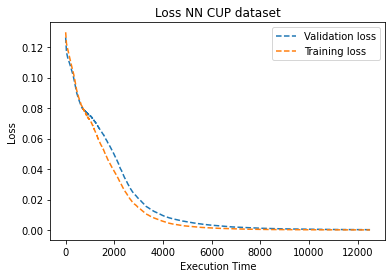

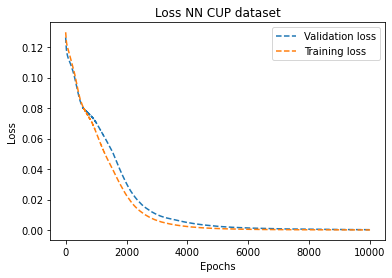

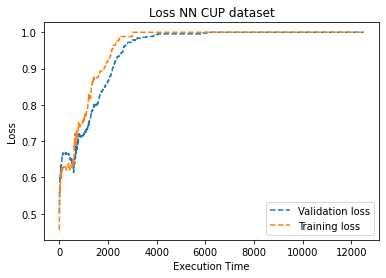

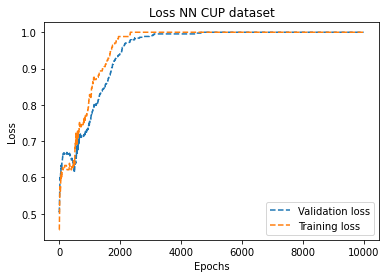

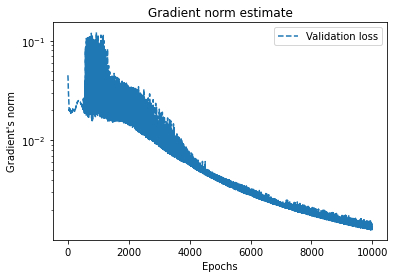

ep: 10000   | s: [3] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 1.36480e-03 | Loss: 2.45017e-04, 8.12541e-05 | Score:     1, 1    
ended in: 12511.4, avg per ep: 1.25114
total update: 0.294, avg updt: 2.94e-05
total ff: 30000, total ff time: 5064.378999999961, avg ff: 0.16881263333333202
total bp: 10000, total bp time: 1829.2300000000137, avg bp: 0.18292300000000136
total ev: 10000, total ev time: 6029.77500000001, avg ev: 0.6029775000000009




<Figure size 432x288 with 0 Axes>

In [62]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [64]:
test = "SGD"
dataset = "monk3"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 9.19477e-02 || Loss: 1.14182e-01, 1.17494e-01 || Score: 0.618, 0.598
2       || Gradient norm: 9.17880e-02 || Loss: 1.14046e-01, 1.17332e-01 || Score: 0.618, 0.598
3       || Gradient norm: 9.14949e-02 || Loss: 1.13853e-01, 1.17102e-01 || Score: 0.623, 0.598
4       || Gradient norm: 9.10829e-02 || Loss: 1.13611e-01, 1.16813e-01 || Score: 0.625, 0.598
5       || Gradient norm: 9.05655e-02 || Loss: 1.13324e-01, 1.16471e-01 || Score: 0.623, 0.598
6       || Gradient norm: 8.96941e-02 || Loss: 1.13000e-01, 1.16084e-01 || Score: 0.627, 0.615
7       || Gradient norm: 8.88683e-02 || Loss: 1.12643e-01, 1.15659e-01 || Score: 0.627, 0.615
8       || Gradient norm: 8.81142e-02 || Loss: 1.12259e-01, 1.15201e-01 || Score:  0.63, 0.615
9       || Gradient norm: 8.68813e-02 || Loss: 1.11853e-01, 1.14717e-01 || Score:  0.63, 0.607
10      || Gradient norm: 8.61195e-02 || Loss: 1.11426e-01, 1.14208e-01 || Score:  0.63, 0.607
11      || Gradient norm: 8.59265e-02 || Loss: 1.1

NC(batch_size=122, debug=True, epochs=10000, eps=0.001, eta=0.01, lmbda=0.01,
   momentum=0.9, sizes=[5])

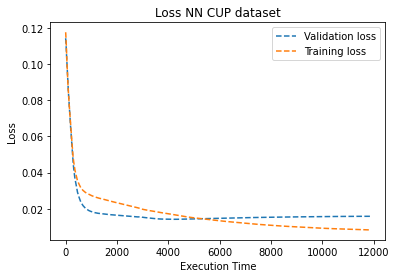

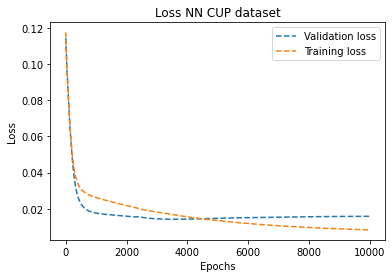

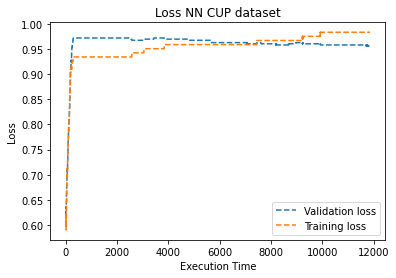

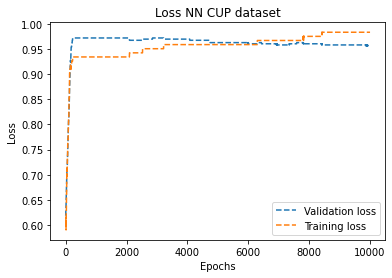

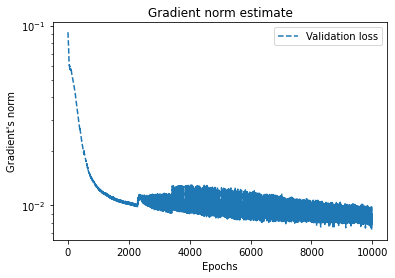

ep: 10000   | s: [5] | b: 122 | e: 0.01 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 8.09917e-03 | Loss: 1.42027e-02, 1.71049e-02 | Score: 0.972, 0.934
ended in: 11859.287, avg per ep: 1.1859287
total update: 0.377, avg updt: 3.77e-05
total ff: 30000, total ff time: 4875.843999999993, avg ff: 0.1625281333333331
total bp: 10000, total bp time: 1750.543999999998, avg bp: 0.1750543999999998
total ev: 10000, total ev time: 5758.382000000007, avg ev: 0.5758382000000006




<Figure size 432x288 with 0 Axes>

In [65]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

## SGM

In [66]:
test = "SGM"
dataset = "monk1"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 9.99730e-02 || Loss: 1.33960e-01, 1.28003e-01 || Score: 0.537, 0.524
2       || Gradient norm: 9.12170e-02 || Loss: 1.17702e-01, 1.05973e-01 || Score: 0.602, 0.71 
3       || Gradient norm: 3.39843e-02 || Loss: 1.12740e-01, 9.84061e-02 || Score: 0.632, 0.75 
4       || Gradient norm: 3.35356e-02 || Loss: 1.08611e-01, 9.19112e-02 || Score: 0.655, 0.774
5       || Gradient norm: 3.10263e-02 || Loss: 1.05663e-01, 8.70320e-02 || Score: 0.685, 0.806
6       || Gradient norm: 3.06165e-02 || Loss: 1.02690e-01, 8.31141e-02 || Score:  0.69, 0.798
7       || Gradient norm: 2.78522e-02 || Loss: 1.01424e-01, 8.04087e-02 || Score: 0.701, 0.831
8       || Gradient norm: 2.91241e-02 || Loss: 9.83933e-02, 7.75449e-02 || Score:  0.72, 0.823
9       || Gradient norm: 2.58501e-02 || Loss: 9.79290e-02, 7.55958e-02 || Score: 0.713, 0.831
10      || Gradient norm: 2.74617e-02 || Loss: 9.39368e-02, 7.28238e-02 || Score: 0.736, 0.831
11      || Gradient norm: 2.31643e-02 || Loss: 9.3

NC(batch_size=124, debug=True, epochs=10000, eps=0.001, lmbda=0.0,
   optimizer='SGM', sizes=[5])

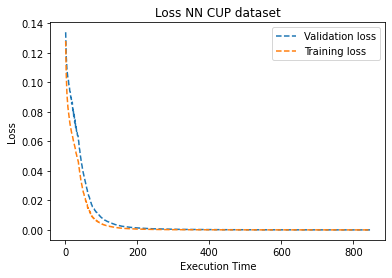

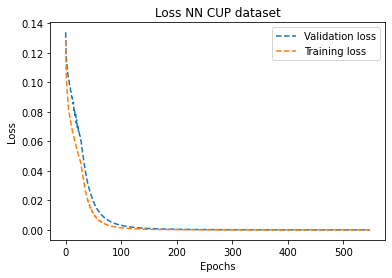

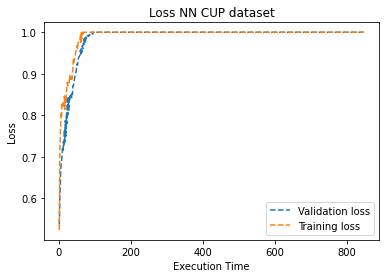

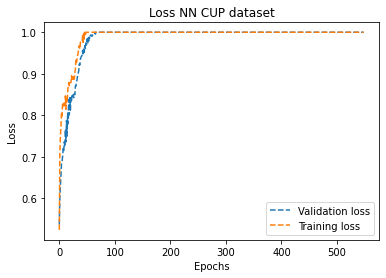

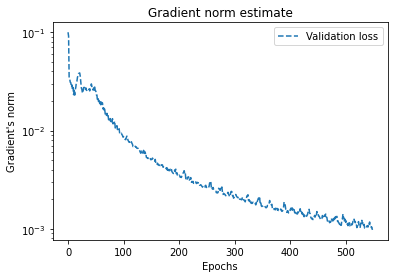

ep: 10000   | s: [5] | b: 124 | e:  0.1 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 9.76228e-04 | Loss: 2.49729e-05, 1.05743e-05 | Score:     1, 1    
ended in: 846.197, avg per ep: 0.0846197
total update: 0.694, avg updt: 6.939999999999999e-05
total ff: 1647, total ff time: 295.9090000000002, avg ff: 0.17966545233758363
total bp: 549, total bp time: 207.89999999999986, avg bp: 0.37868852459016367
total ev: 549, total ev time: 369.94800000000015, avg ev: 0.673857923497268




<Figure size 432x288 with 0 Axes>

In [67]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [68]:
test = "SGM"
dataset = "monk2"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 4.50686e-02 || Loss: 1.23866e-01, 1.27600e-01 || Score: 0.528, 0.491
2       || Gradient norm: 3.97793e-02 || Loss: 1.22213e-01, 1.26222e-01 || Score: 0.546, 0.515
3       || Gradient norm: 3.50116e-02 || Loss: 1.21092e-01, 1.25243e-01 || Score: 0.565, 0.544
4       || Gradient norm: 3.24217e-02 || Loss: 1.20219e-01, 1.24463e-01 || Score: 0.567, 0.562
5       || Gradient norm: 3.07242e-02 || Loss: 1.19510e-01, 1.23806e-01 || Score: 0.581, 0.568
6       || Gradient norm: 2.90498e-02 || Loss: 1.18925e-01, 1.23264e-01 || Score: 0.586, 0.574
7       || Gradient norm: 2.74537e-02 || Loss: 1.18408e-01, 1.22801e-01 || Score: 0.597, 0.586
8       || Gradient norm: 2.55055e-02 || Loss: 1.17972e-01, 1.22410e-01 || Score: 0.597, 0.58 
9       || Gradient norm: 2.44776e-02 || Loss: 1.17577e-01, 1.22055e-01 || Score:   0.6, 0.586
10      || Gradient norm: 2.36208e-02 || Loss: 1.17226e-01, 1.21729e-01 || Score: 0.597, 0.574
11      || Gradient norm: 2.25938e-02 || Loss: 1.1

NC(batch_size=169, debug=True, epochs=10000, eps=0.001, eta=0.01, lmbda=0.0,
   optimizer='SGM', sizes=[3])

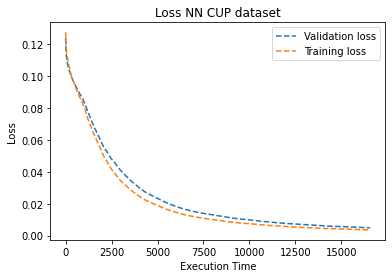

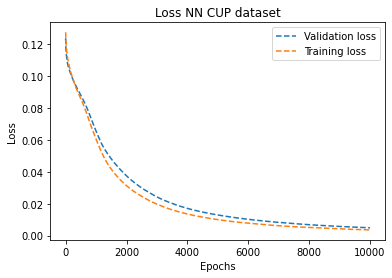

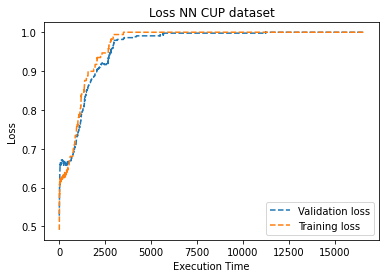

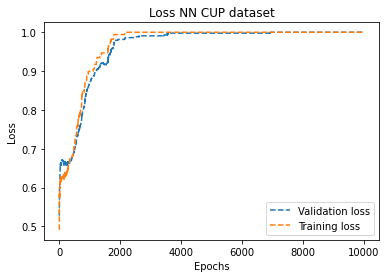

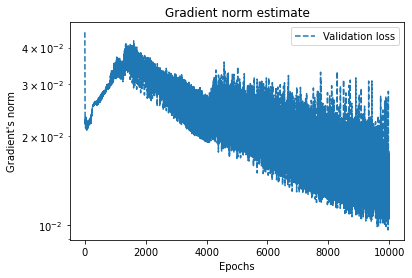

ep: 10000   | s: [3] | b: 169 | e: 0.01 | lmbda:  0.0 | m:  0.5 | nesterov: False
Grad: 1.29816e-02 | Loss: 4.85240e-03, 3.52318e-03 | Score:     1, 1    
ended in: 16562.783, avg per ep: 1.6562782999999999
total update: 0.835, avg updt: 8.35e-05
total ff: 30000, total ff time: 5680.161000000066, avg ff: 0.18933870000000222
total bp: 10000, total bp time: 4193.0109999999895, avg bp: 0.4193010999999989
total ev: 10000, total ev time: 7065.66400000001, avg ev: 0.7065664000000009




<Figure size 432x288 with 0 Axes>

In [69]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [70]:
test = "SGD"
dataset = "monk3"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 9.19477e-02 || Loss: 1.14182e-01, 1.17494e-01 || Score: 0.618, 0.598
2       || Gradient norm: 9.17880e-02 || Loss: 1.14046e-01, 1.17332e-01 || Score: 0.618, 0.598
3       || Gradient norm: 9.14949e-02 || Loss: 1.13853e-01, 1.17102e-01 || Score: 0.623, 0.598
4       || Gradient norm: 9.10829e-02 || Loss: 1.13611e-01, 1.16813e-01 || Score: 0.625, 0.598
5       || Gradient norm: 9.05655e-02 || Loss: 1.13324e-01, 1.16471e-01 || Score: 0.623, 0.598
6       || Gradient norm: 8.96941e-02 || Loss: 1.13000e-01, 1.16084e-01 || Score: 0.627, 0.615
7       || Gradient norm: 8.88683e-02 || Loss: 1.12643e-01, 1.15659e-01 || Score: 0.627, 0.615
8       || Gradient norm: 8.81142e-02 || Loss: 1.12259e-01, 1.15201e-01 || Score:  0.63, 0.615
9       || Gradient norm: 8.68813e-02 || Loss: 1.11853e-01, 1.14717e-01 || Score:  0.63, 0.607
10      || Gradient norm: 8.61195e-02 || Loss: 1.11426e-01, 1.14208e-01 || Score:  0.63, 0.607
11      || Gradient norm: 8.59265e-02 || Loss: 1.1

NC(batch_size=122, debug=True, epochs=10000, eps=0.001, eta=0.01, lmbda=0.01,
   momentum=0.9, sizes=[5])

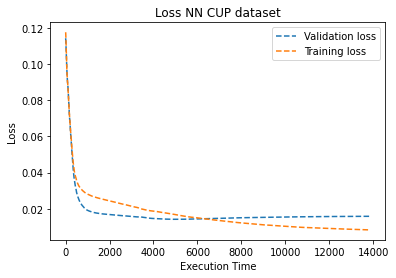

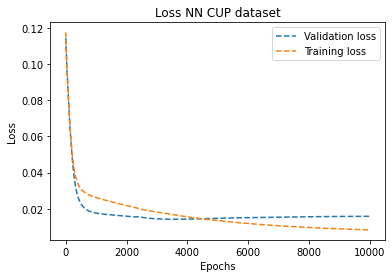

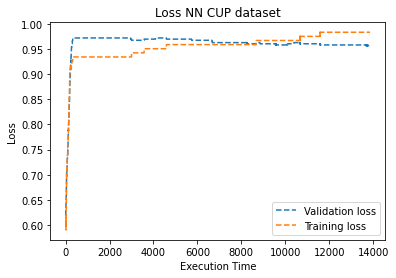

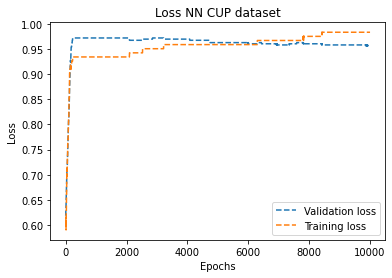

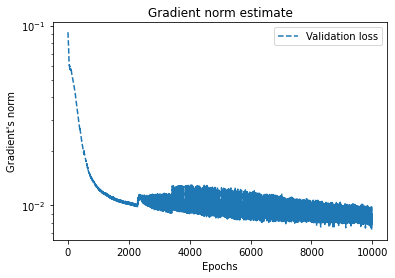

ep: 10000   | s: [5] | b: 122 | e: 0.01 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 8.09917e-03 | Loss: 1.42027e-02, 1.71049e-02 | Score: 0.972, 0.934
ended in: 13858.904, avg per ep: 1.3858904
total update: 0.75, avg updt: 7.5e-05
total ff: 30000, total ff time: 5626.886000000058, avg ff: 0.1875628666666686
total bp: 10000, total bp time: 2074.923000000001, avg bp: 0.2074923000000001
total ev: 10000, total ev time: 6990.22600000003, avg ev: 0.6990226000000029




<Figure size 432x288 with 0 Axes>

In [71]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

# Report stats

## Monk1

In [7]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 500, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 500     | s: [5] | b: 32 | e:  0.1 | lmbda:  0.0 | m:  0.9 | nesterov: False
Grad: 3.17537e-03 | Loss: -1.00000e+00, 5.36510e-06 | Score:    -1, 1    
ended in: 720.149, avg per ep: 1.440298
total update: 1.173, avg updt: 0.002346
total ff: 2500, total ff time: 187.61999999999986, avg ff: 0.07504799999999995
total bp: 2000, total bp time: 182.28500000000025, avg bp: 0.09114250000000013
total ev: 500, total ev time: 98.80200000000016, avg ev: 0.19760400000000033

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 500, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.0, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 500     | s: [5] | b: 32 | e:  0.1 | lmbda:  0.0 | m:  0.9 | nesterov: True
Grad: 1.30154e-03 | Loss: -1.00000e+00, 7.92283e-07 | Score:    -1, 1    
ended 

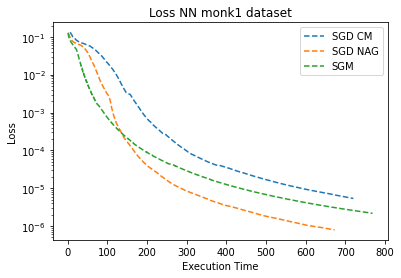

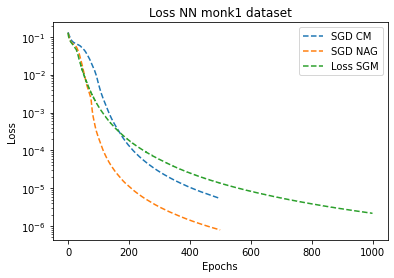

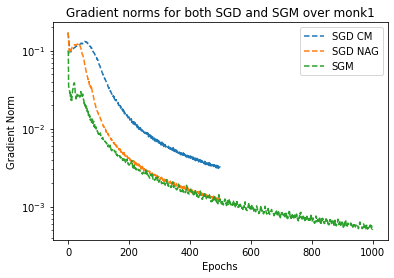

<Figure size 432x288 with 0 Axes>

In [8]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## Monk2

In [9]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 500, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [3], 'debug': True}
ep: 500     | s: [3] | b: 32 | e: 0.01 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 4.44481e-02 | Loss: -1.00000e+00, 1.16427e-01 | Score:    -1, 0.639
ended in: 676.377, avg per ep: 1.352754
total update: 0.829, avg updt: 0.001658
total ff: 3500, total ff time: 171.08100000000022, avg ff: 0.04888028571428578
total bp: 3000, total bp time: 179.20500000000007, avg bp: 0.059735000000000024
total ev: 500, total ev time: 76.61200000000005, avg ev: 0.1532240000000001

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 500, 'eps': 1e-06, 'eta': 0.01, 'lmbda': 0.01, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [3], 'debug': True}
ep: 500     | s: [3] | b: 32 | e: 0.01 | lmbda: 0.01 | m:  0.5 | nesterov: True
Grad: 4.44971e-02 | Loss: -1.00000e+00, 1.13464e-01 | Score:    -1, 0.633
en

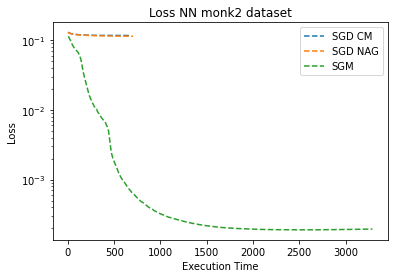

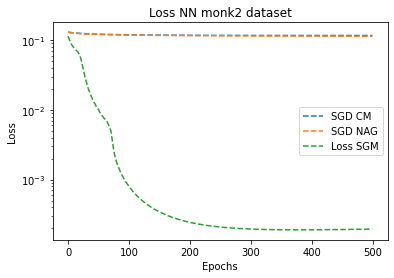

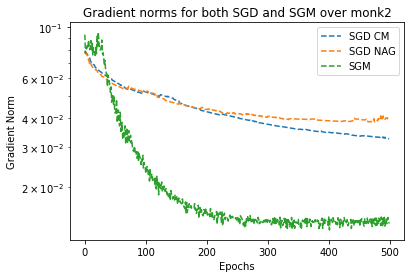

<Figure size 432x288 with 0 Axes>

In [10]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## Monk3

In [11]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 10, 'epochs': 500, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 500     | s: [5] | b: 10 | e:  0.1 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 1.63550e-02 | Loss: -1.00000e+00, 8.94503e-03 | Score:    -1, 0.984
ended in: 1758.6950000000002, avg per ep: 3.5173900000000002
total update: 3.549, avg updt: 0.007098
total ff: 7000, total ff time: 431.85100000000006, avg ff: 0.061693000000000005
total bp: 6500, total bp time: 497.24900000000076, avg bp: 0.07649984615384627
total ev: 500, total ev time: 111.40199999999993, avg ev: 0.22280399999999986

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 10, 'epochs': 500, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 500     | s: [5] | b: 10 | e:  0.1 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 7.10682e-03 | Loss: -1.00000e+00, 3.39127e-03 | S

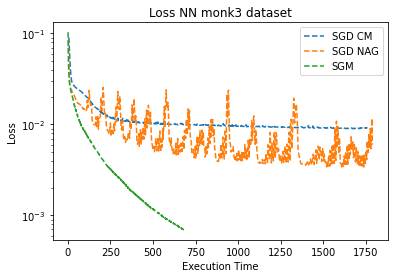

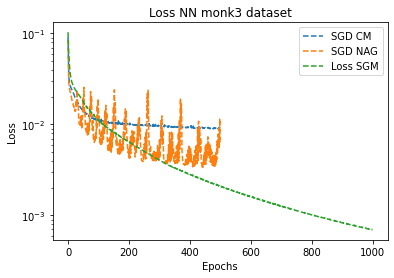

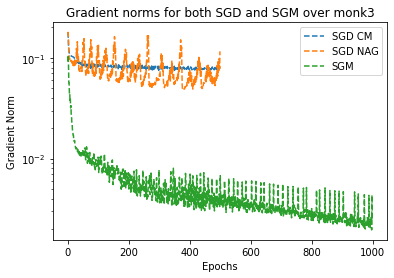

<Figure size 432x288 with 0 Axes>

In [12]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## CUP

In [12]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': 32, 'epochs': 1000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: False
Grad: 3.75936e+01 | Loss: -1.00000e+00, 2.77330e+00 | Score:    -1, 0.958
ended in: 20059.615, avg per ep: 20.059615
total update: 21.011, avg updt: 0.021011
total ff: 35000, total ff time: 6428.028000000114, avg ff: 0.18365794285714612
total bp: 34000, total bp time: 6361.694000000042, avg bp: 0.18710864705882477
total ev: 1000, total ev time: 2783.9160000000034, avg ev: 2.783916000000003

 

----- SGD nesterov-----
{'batch_size': 32, 'epochs': 1000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: True
Grad: 3.75936e+01 | Loss: -1.00000e+00, 2.7733

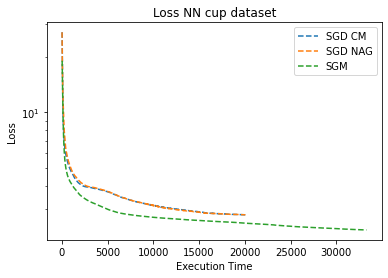

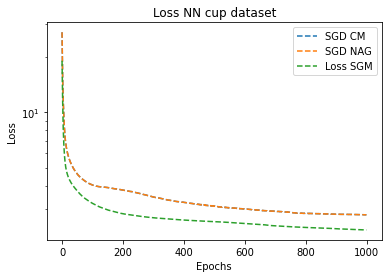

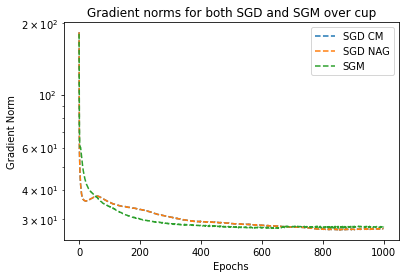

<Figure size 432x288 with 0 Axes>

In [13]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

# MONK stats

In [25]:
X_train_monk1, X_test_monk1, y_train_monk1, y_test_monk1 = utils.load_monk(datasets['monk1'])
X_train_monk2, X_test_monk2, y_train_monk2, y_test_monk2 = utils.load_monk(datasets['monk3'])
X_train_monk3, X_test_monk3, y_train_monk3, y_test_monk3 = utils.load_monk(datasets['monk3'])

## MONK1

### Best grid execution

{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 500, 'eps': 1e-06, 'eta': 0.1, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
1       || Gradient norm: 1.34409e-01 || Loss: 1.30009e-01, 1.28058e-01 || Score: 0.532, 0.524
2       || Gradient norm: 1.75536e-01 || Loss: 1.24243e-01, 1.18255e-01 || Score: 0.565, 0.597
3       || Gradient norm: 1.75189e-01 || Loss: 1.19824e-01, 1.11008e-01 || Score: 0.583, 0.629
4       || Gradient norm: 1.26607e-01 || Loss: 1.12981e-01, 1.01275e-01 || Score: 0.655, 0.75 
5       || Gradient norm: 8.82704e-02 || Loss: 1.08935e-01, 9.48572e-02 || Score: 0.678, 0.774
6       || Gradient norm: 8.30640e-02 || Loss: 1.06192e-01, 8.99188e-02 || Score: 0.678, 0.766
7       || Gradient norm: 8.51800e-02 || Loss: 1.02583e-01, 8.45232e-02 || Score: 0.692, 0.79 
8       || Gradient norm: 1.00606e-01 || Loss: 9.93082e-02, 8.00983e-02 || Score: 0.718, 0.79 
9       || Gradient norm: 1.13763e-01 || Loss: 9.71633e-02, 7.71453e-02 || S

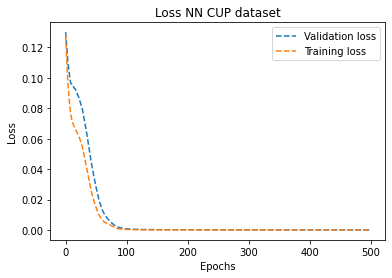

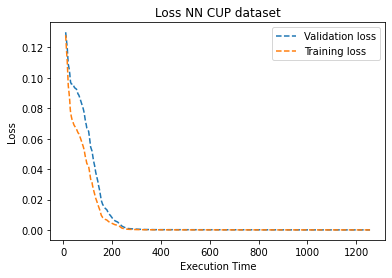

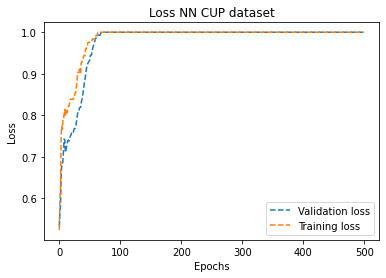

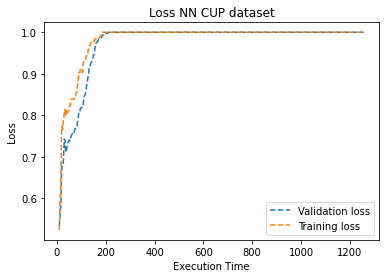

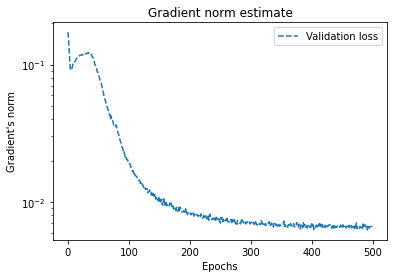

ep: 500     | s: [] | b: 32 | e:  0.1 | lmbda: 0.01 | m:  0.9
Grad: 6.80164e-03 | Loss: 5.06798e-05, 3.08887e-05 | Score:     1, 1    
ended in: 1256.526, avg per ep: 2.513052
total update: 1.487, avg updt: 0.002974
total ff: 3000, total ff time: 370.7339999999992, avg ff: 0.12357799999999973
total bp: 2000, total bp time: 202.00800000000064, avg bp: 0.10100400000000032
total ev: 500, total ev time: 471.43599999999964, avg ev: 0.9428719999999993




<Figure size 432x288 with 0 Axes>

In [27]:
plot_MONK_stats(params, "monk1", "SGD", X_train_monk1, y_train_monk1, X_test_monk1, y_test_monk1)

{'batch_size': 10, 'epochs': 1000, 'eps': 0.001, 'eta': 0.1, 'lmbda': 0.001, 'optimizer': 'SGM', 'sizes': [5], 'debug': False}


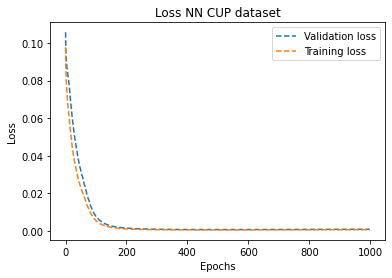

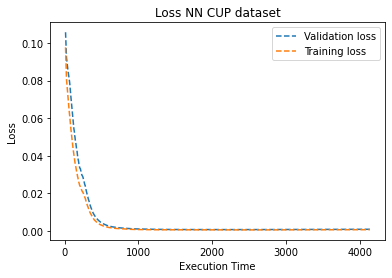

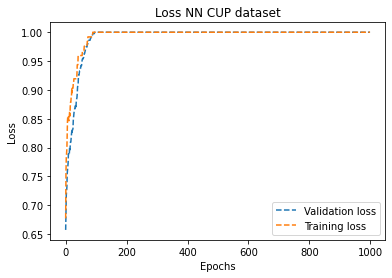

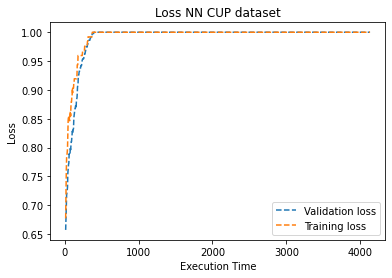

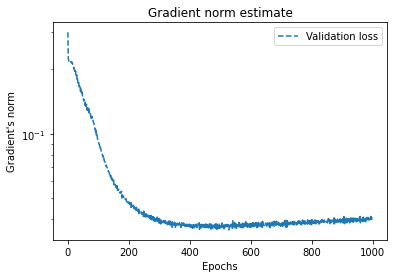

ep: 1000    | s: [] | b: 10 | e:  0.1 | lmbda:0.001 | m:  0.5
Grad: 4.79977e-02 | Loss: 7.85140e-04, 6.08881e-04 | Score:     1, 1    
ended in: 4133.849, avg per ep: 4.1338490000000006
total update: 3.436, avg updt: 0.003436
total ff: 15000, total ff time: 632.5600000000073, avg ff: 0.042170666666667155
total bp: 13000, total bp time: 1970.3060000001128, avg bp: 0.1515620000000087
total ev: 1000, total ev time: 285.19600000000133, avg ev: 0.28519600000000134




<Figure size 432x288 with 0 Axes>

In [7]:
plot_MONK_stats(params, "monks-1", "SGM", X_train_monk1, y_train_monk1, X_test_monk1, y_test_monk1)


### Specified precision comparison

In [9]:
dataset = 'monks-1'
test_SGD = "SGD"
test_SGM = "SGM"

conf = params.copy()
conf[dataset][test_SGD]['eps'] = 5e-4
conf[dataset][test_SGM]['eps'] = 5e-4

conf[dataset][test_SGD]['epochs'] = 5000
conf[dataset][test_SGM]['epochs'] = 5000

conf[dataset][test_SGD]['batch_size'] = None
conf[dataset][test_SGM]['batch_size'] = None


{'activation': 'Lrelu', 'batch_size': None, 'epochs': 5000, 'eps': 0.0005, 'eta': 0.1, 'lmbda': 0.0001, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': False}
0.0004999695077498215 0.0005
Reached desired precision in gradient norm, stopping.


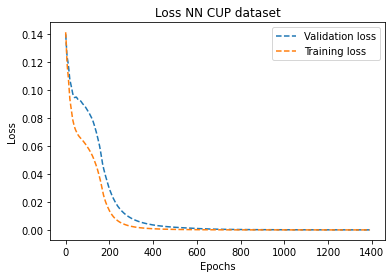

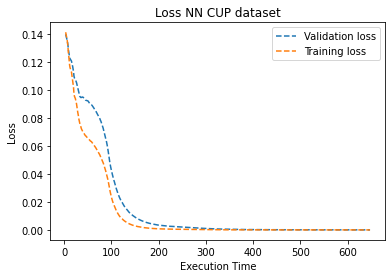

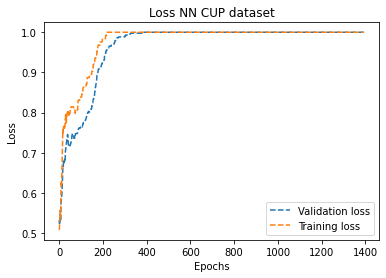

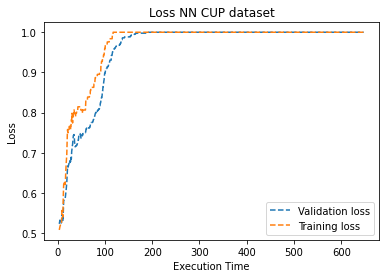

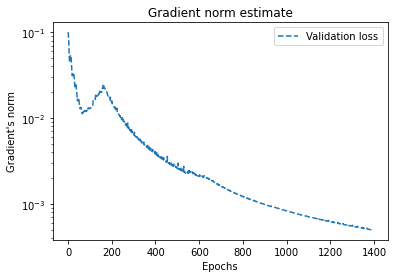

ep: 5000    | s: [] | b: 124 | e:  0.1 | lmbda:0.0001 | m:  0.9
Grad: 4.99970e-04 | Loss: 3.68464e-05, 5.14856e-06 | Score:     1, 1    
ended in: 647.613, avg per ep: 0.12952260000000002
total update: 0.179, avg updt: 3.5799999999999996e-05
total ff: 4179, total ff time: 216.62400000000298, avg ff: 0.05183632447954127
total bp: 1393, total bp time: 87.13700000000114, avg bp: 0.06255348169418602
total ev: 1393, total ev time: 320.24899999999934, avg ev: 0.22989877961234698




<Figure size 432x288 with 0 Axes>

In [10]:
plot_MONK_stats(conf, dataset, test_SGD, X_train_monk1, y_train_monk1, X_test_monk1, y_test_monk1)

{'batch_size': None, 'epochs': 5000, 'eps': 0.0005, 'eta': 0.1, 'lmbda': 0.001, 'optimizer': 'SGM', 'sizes': [5], 'debug': False}
SGM - grad:0.0004796509638954897, eps: 0.0005
Reached desired precision in gradient norm, stopping.


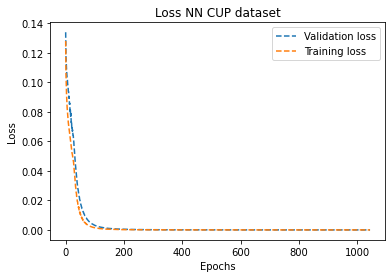

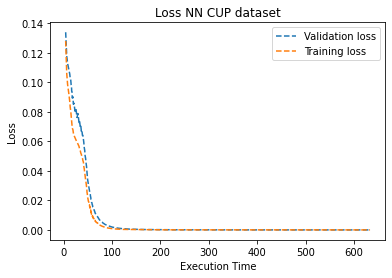

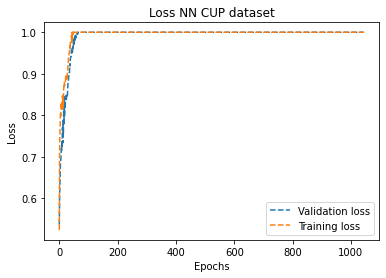

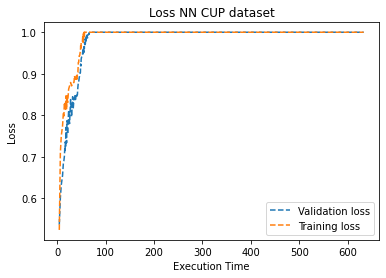

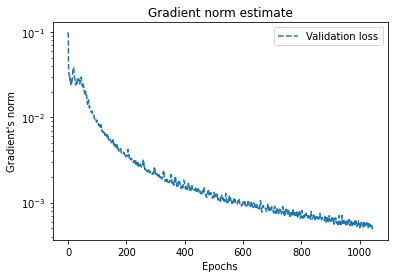

ep: 5000    | s: [] | b: 124 | e:  0.1 | lmbda:0.001 | m:  0.5
Grad: 4.79651e-04 | Loss: 4.71163e-06, 2.13997e-06 | Score:     1, 1    
ended in: 632.861, avg per ep: 0.1265722
total update: 0.275, avg updt: 5.5e-05
total ff: 3135, total ff time: 174.0409999999967, avg ff: 0.05551547049441681
total bp: 1045, total bp time: 180.27999999999994, avg bp: 0.1725167464114832
total ev: 1045, total ev time: 255.22699999999813, avg ev: 0.24423636363636184




<Figure size 432x288 with 0 Axes>

In [11]:
plot_MONK_stats(conf, dataset, test_SGM, X_train_monk1, y_train_monk1, X_test_monk1, y_test_monk1)

## MONK2

### Best grid execution

{'activation': 'Lrelu', 'batch_size': 10, 'epochs': 500, 'eps': 0.0001, 'eta': 0.1, 'lmbda': 0.0001, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [3], 'debug': False}


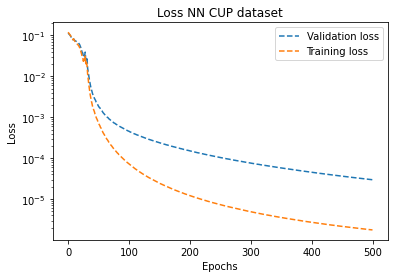

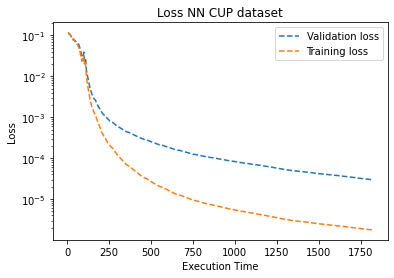

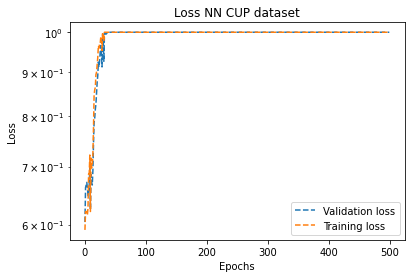

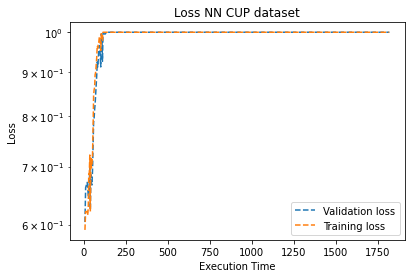

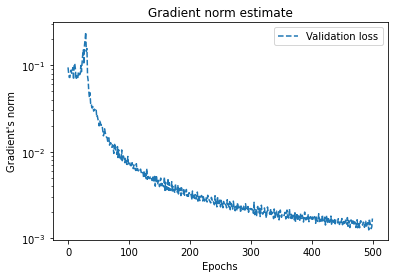

ep: 500     | s: [3] | b: 10 | e:  0.1 | lmbda:0.0001 | m:  0.9
Grad: 2.91090e-03 | Loss: 2.97697e-05, 1.76808e-06 | Score:     1, 1    
ended in: 1820.345, avg per ep: 3.64069
total update: 3.332, avg updt: 0.006664
total ff: 9500, total ff time: 462.4389999999953, avg ff: 0.048677789473683716
total bp: 8500, total bp time: 506.95799999999855, avg bp: 0.05964211764705865
total ev: 500, total ev time: 173.7079999999999, avg ev: 0.34741599999999984




<Figure size 432x288 with 0 Axes>

In [10]:
plot_MONK_stats(params, "monk2", "SGD", X_train_monk2, y_train_monk2, X_test_monk2, y_test_monk2)

{'batch_size': 10, 'epochs': 500, 'eps': 0.001, 'eta': 0.1, 'lmbda': 0.0, 'optimizer': 'SGM', 'sizes': [3], 'debug': False}


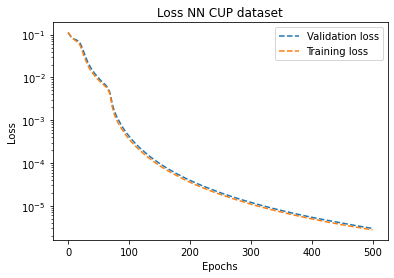

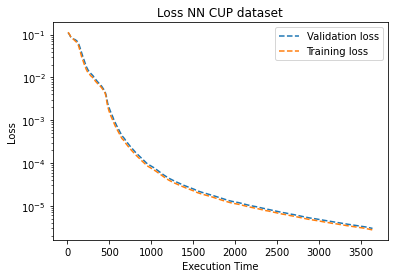

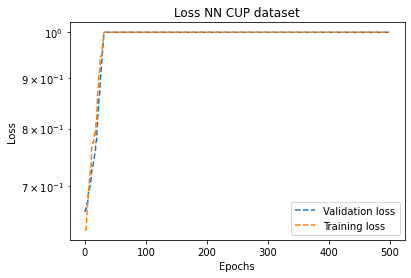

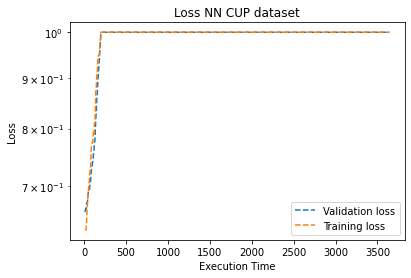

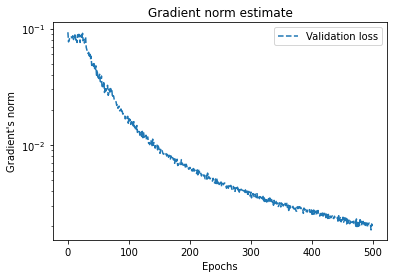

ep: 500     | s: [3] | b: 10 | e:  0.1 | lmbda:  0.0 | m:  0.5
Grad: 2.36891e-03 | Loss: 2.96746e-06, 2.73439e-06 | Score:     1, 1    
ended in: 3642.2619999999997, avg per ep: 7.284523999999999
total update: 5.251, avg updt: 0.010502000000000001
total ff: 9500, total ff time: 567.9950000000017, avg ff: 0.05978894736842123
total bp: 8500, total bp time: 1837.9020000000025, avg bp: 0.21622376470588264
total ev: 500, total ev time: 198.80000000000004, avg ev: 0.39760000000000006




<Figure size 432x288 with 0 Axes>

In [11]:
plot_MONK_stats(params, "monk2", "SGM", X_train_monk2, y_train_monk2, X_test_monk2, y_test_monk2)


### Specified precision

In [12]:
dataset = 'monk2'
test_SGD = "SGD"
test_SGM = "SGM"

conf = params.copy()
conf[dataset][test_SGD]['eps'] = 5e-4
conf[dataset][test_SGM]['eps'] = 5e-4

conf[dataset][test_SGD]['epochs'] = 5000
conf[dataset][test_SGM]['epochs'] = 5000

conf[dataset][test_SGD]['batch_size'] = None
conf[dataset][test_SGM]['batch_size'] = None


{'activation': 'Lrelu', 'batch_size': None, 'epochs': 5000, 'eps': 0.0005, 'eta': 0.1, 'lmbda': 0.0001, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [3], 'debug': False}
Reached desired precision in gradient norm, stopping.


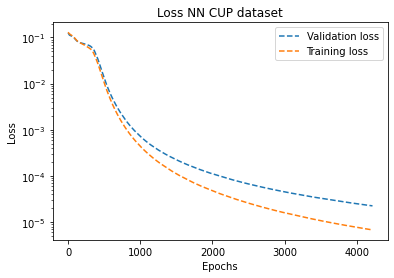

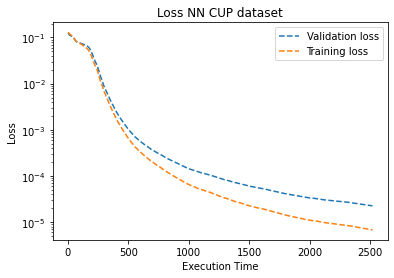

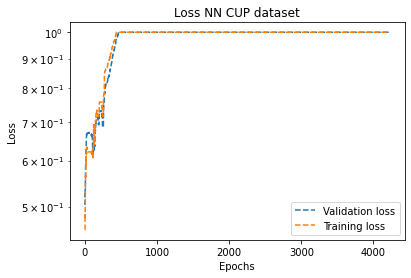

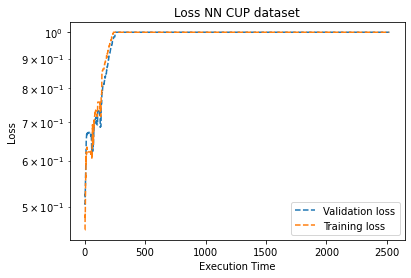

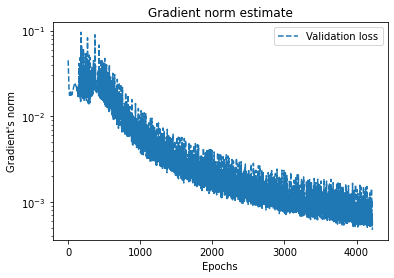

ep: 5000    | s: [3] | b: 169 | e:  0.1 | lmbda:0.0001 | m:  0.9
Grad: 4.74175e-04 | Loss: 2.24929e-05, 6.77436e-06 | Score:     1, 1    
ended in: 2521.378, avg per ep: 0.5042756
total update: 0.195, avg updt: 3.9e-05
total ff: 12663, total ff time: 934.9850000000087, avg ff: 0.07383597883597952
total bp: 4221, total bp time: 398.2040000000025, avg bp: 0.09433878227908138
total ev: 4221, total ev time: 1339.788000000002, avg ev: 0.3174100923951675




<Figure size 432x288 with 0 Axes>

In [13]:
plot_MONK_stats(conf, dataset, test_SGD, X_train_monk2, y_train_monk2, X_test_monk2, y_test_monk2)

{'batch_size': None, 'epochs': 5000, 'eps': 0.0005, 'eta': 0.1, 'lmbda': 0.0, 'optimizer': 'SGM', 'sizes': [3], 'debug': False}
Reached desired precision in gradient norm, stopping.


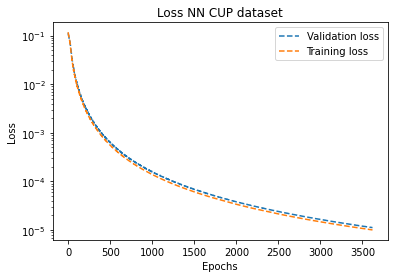

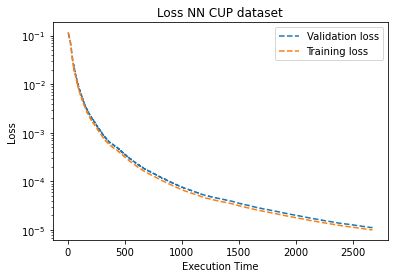

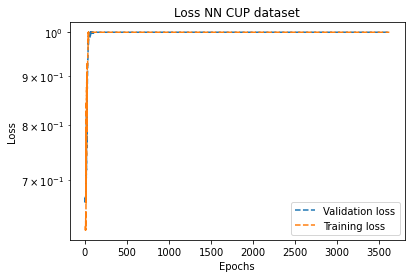

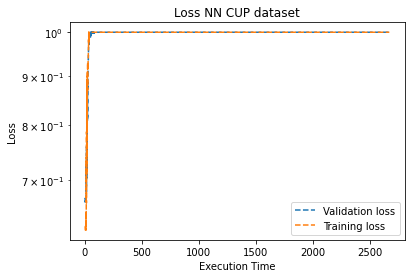

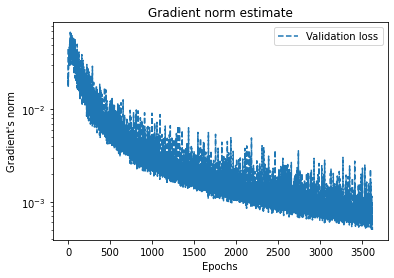

ep: 5000    | s: [3] | b: 169 | e:  0.1 | lmbda:  0.0 | m:  0.5
Grad: 4.97250e-04 | Loss: 1.12146e-05, 1.00688e-05 | Score:     1, 1    
ended in: 2672.114, avg per ep: 0.5344228
total update: 0.604, avg updt: 0.0001208
total ff: 10860, total ff time: 763.1009999999959, avg ff: 0.07026712707182282
total bp: 3620, total bp time: 830.9390000000013, avg bp: 0.22954116022099486
total ev: 3620, total ev time: 1100.5279999999957, avg ev: 0.3040132596685071




<Figure size 432x288 with 0 Axes>

In [14]:
plot_MONK_stats(conf, dataset, test_SGM, X_train_monk2, y_train_monk2, X_test_monk2, y_test_monk2)

## MONK3

### Best grid execution

{'activation': 'Lrelu', 'batch_size': 10, 'epochs': 500, 'eps': 0.0001, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5], 'debug': False}


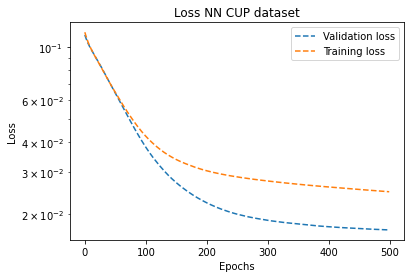

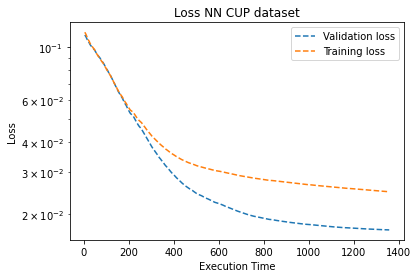

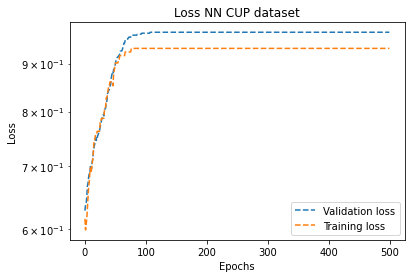

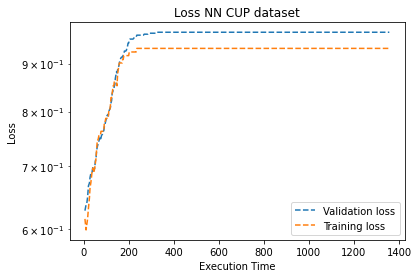

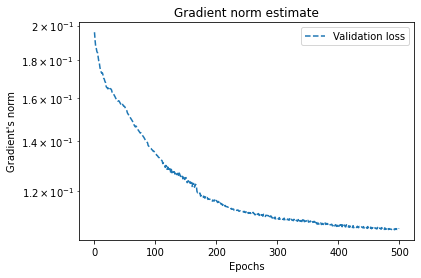

ep: 500     | s: [5] | b: 10 | e: 0.01 | lmbda:0.0001 | m:  0.5
Grad: 4.67238e-02 | Loss: 1.72087e-02, 2.48524e-02 | Score: 0.972, 0.934
ended in: 1357.033, avg per ep: 2.714066
total update: 2.679, avg updt: 0.005358
total ff: 7500, total ff time: 355.55899999999536, avg ff: 0.04740786666666605
total bp: 6500, total bp time: 368.7199999999975, avg bp: 0.05672615384615347
total ev: 500, total ev time: 166.22700000000003, avg ev: 0.3324540000000001




<Figure size 432x288 with 0 Axes>

In [15]:
plot_MONK_stats(params, "monk3", "SGD", X_train_monk3, y_train_monk3, X_test_monk3, y_test_monk3)

{'batch_size': 32, 'epochs': 500, 'eps': 0.001, 'eta': 0.1, 'lmbda': 0.01, 'optimizer': 'SGM', 'sizes': [2], 'debug': False}


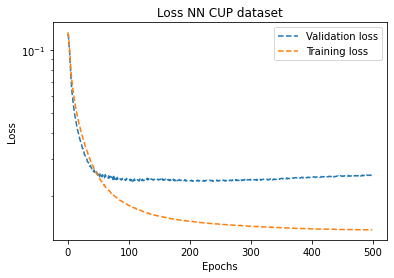

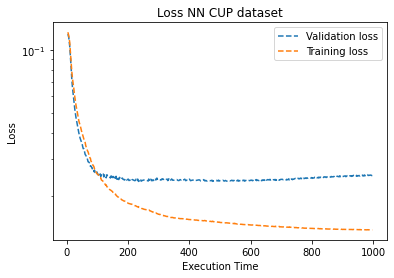

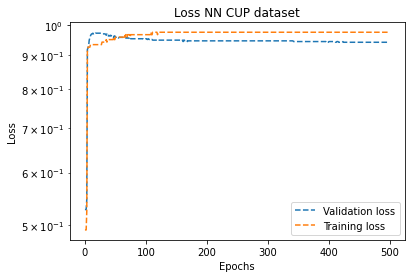

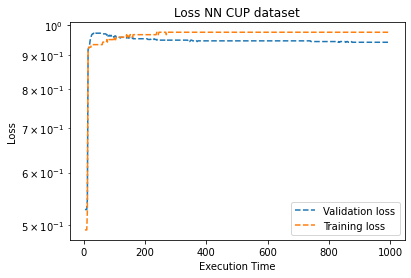

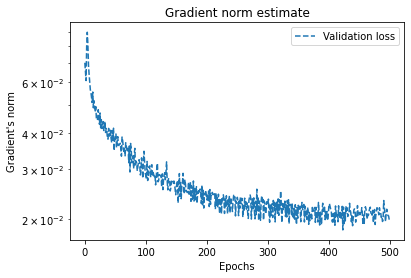

ep: 500     | s: [2] | b: 32 | e:  0.1 | lmbda: 0.01 | m:  0.5
Grad: 1.36338e-02 | Loss: 2.33998e-02, 1.77201e-02 | Score: 0.972, 0.934
ended in: 997.119, avg per ep: 1.994238
total update: 1.757, avg updt: 0.0035139999999999998
total ff: 3000, total ff time: 192.24399999999994, avg ff: 0.06408133333333331
total bp: 2000, total bp time: 437.2829999999999, avg bp: 0.21864149999999996
total ev: 500, total ev time: 170.40700000000012, avg ev: 0.34081400000000023




<Figure size 432x288 with 0 Axes>

In [16]:
plot_MONK_stats(params, "monk3", "SGM", X_train_monk3, y_train_monk3, X_test_monk3, y_test_monk3)


### Specified precision

In [28]:
dataset = 'monk3'
test_SGD = "SGD"
test_SGM = "SGM"

conf = params.copy()
conf[dataset][test_SGD]['eps'] = 5e-4
conf[dataset][test_SGM]['eps'] = 5e-4

conf[dataset][test_SGD]['epochs'] = 5000
conf[dataset][test_SGM]['epochs'] = 5000

conf[dataset][test_SGD]['batch_size'] = None
conf[dataset][test_SGM]['batch_size'] = None


{'activation': 'Lrelu', 'batch_size': None, 'epochs': 5000, 'eps': 0.0005, 'eta': 0.01, 'lmbda': 0.0001, 'momentum': 0.5, 'optimizer': 'SGD', 'sizes': [5], 'debug': False}


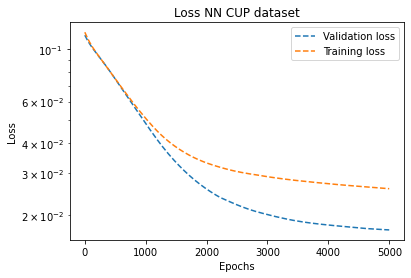

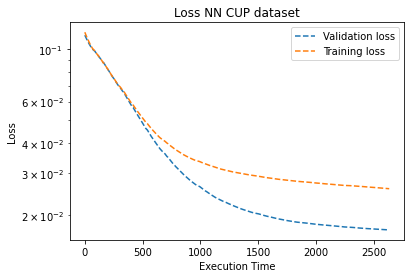

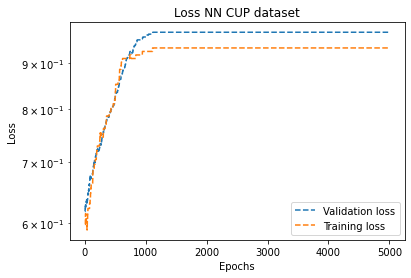

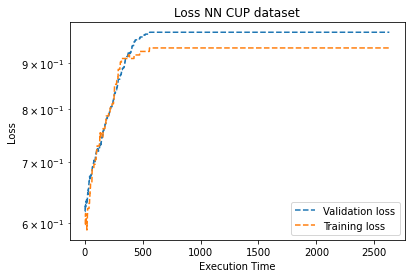

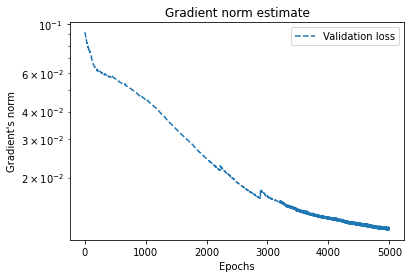

ep: 5000    | s: [5] | b: 122 | e: 0.01 | lmbda:0.0001 | m:  0.5
Grad: 1.15798e-02 | Loss: 1.72884e-02, 2.57781e-02 | Score: 0.972, 0.934
ended in: 2629.64, avg per ep: 0.525928
total update: 0.188, avg updt: 3.76e-05
total ff: 15000, total ff time: 995.20199999999, avg ff: 0.06634679999999933
total bp: 5000, total bp time: 406.45999999999793, avg bp: 0.08129199999999959
total ev: 5000, total ev time: 1407.3660000000068, avg ev: 0.28147320000000137




<Figure size 432x288 with 0 Axes>

In [29]:
plot_MONK_stats(conf, dataset, test_SGD, X_train_monk3, y_train_monk3, X_test_monk3, y_test_monk3)

{'batch_size': None, 'epochs': 5000, 'eps': 0.0005, 'eta': 0.1, 'lmbda': 0.01, 'optimizer': 'SGM', 'sizes': [2], 'debug': False}


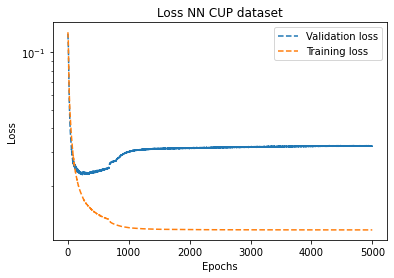

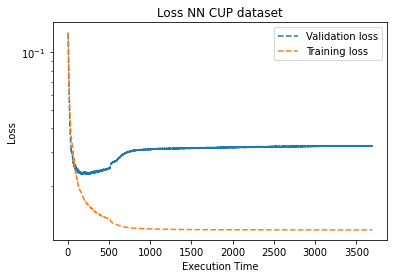

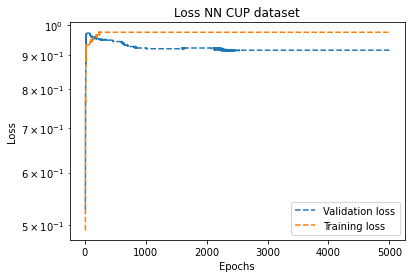

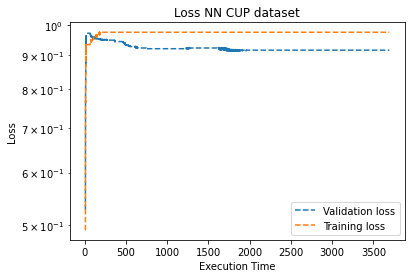

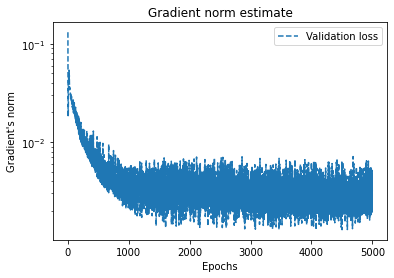

ep: 5000    | s: [2] | b: 122 | e:  0.1 | lmbda: 0.01 | m:  0.5
Grad: 3.25650e-03 | Loss: 2.29573e-02, 1.77270e-02 | Score: 0.972, 0.934
ended in: 3693.109, avg per ep: 0.7386218
total update: 0.387, avg updt: 7.74e-05
total ff: 15000, total ff time: 996.7440000000249, avg ff: 0.06644960000000166
total bp: 5000, total bp time: 1131.174999999999, avg bp: 0.2262349999999998
total ev: 5000, total ev time: 1534.544, avg ev: 0.30690880000000004




<Figure size 432x288 with 0 Axes>

In [22]:
plot_MONK_stats(conf, dataset, test_SGM, X_train_monk3, y_train_monk3, X_test_monk3, y_test_monk3)

Report# CUP statistics

### Best grid execution

{'batch_size': 32, 'epochs': 1000, 'eps': 0.0001, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
1       || Gradient norm: 3.98848e+00 || Loss: 2.13580e-01, 2.24040e-01 || Score: -0.709, -0.792
2       || Gradient norm: 3.80736e+00 || Loss: 1.99709e-01, 2.09760e-01 || Score: -0.598, -0.678
3       || Gradient norm: 3.63999e+00 || Loss: 1.88004e-01, 1.97686e-01 || Score: -0.504, -0.581
4       || Gradient norm: 3.48947e+00 || Loss: 1.78123e-01, 1.87467e-01 || Score: -0.425, -0.5 
5       || Gradient norm: 3.35291e+00 || Loss: 1.69778e-01, 1.78811e-01 || Score: -0.358, -0.43
6       || Gradient norm: 3.22443e+00 || Loss: 1.62731e-01, 1.71483e-01 || Score: -0.302, -0.372
7       || Gradient norm: 3.11004e+00 || Loss: 1.56778e-01, 1.65271e-01 || Score: -0.254, -0.322
8       || Gradient norm: 3.00060e+00 || Loss: 1.51751e-01, 1.60006e-01 || Score: -0.214, -0.28
9       || Gradient norm: 2.89961e+00 || Loss: 1.4750

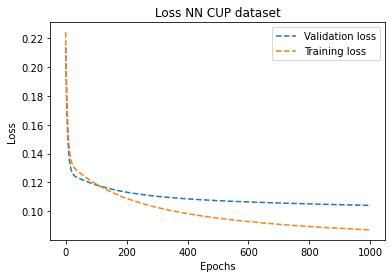

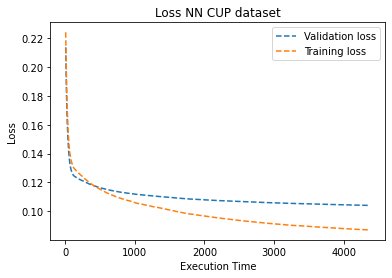

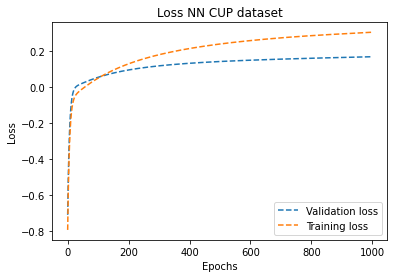

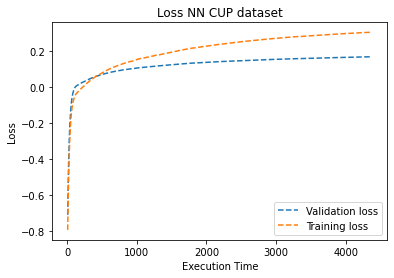

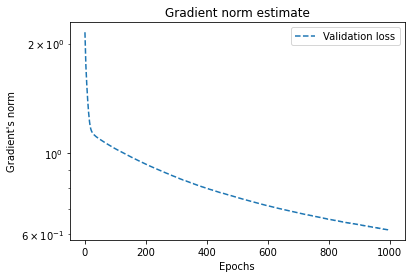

ep: 1000    | s: [] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0
Grad: 8.06579e-01 | Loss: 1.04069e-01, 8.71070e-02 | Score: 0.167, 0.303
ended in: 4377.543, avg per ep: 4.377542999999999
total update: 2.695, avg updt: 0.002695
total ff: 6000, total ff time: 1492.4340000000109, avg ff: 0.24873900000000182
total bp: 4000, total bp time: 685.1779999999968, avg bp: 0.1712944999999992
total ev: 1000, total ev time: 2341.0000000000005, avg ev: 2.3410000000000006




<Figure size 432x288 with 0 Axes>

In [9]:
plot_MONK_stats(params, "cup", "SGD", X_train, y_train, X_test, y_test)

{'batch_size': 32, 'epochs': 1000, 'eps': 0.0001, 'eta': 0.1, 'lmbda': 0.001, 'optimizer': 'SGM', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
1       || Gradient norm: 6.58262e-01 || Loss: 1.36444e-01, 1.17733e-01 || Score: -0.0916, 0.0581
2       || Gradient norm: 6.51956e-01 || Loss: 1.20389e-01, 9.31133e-02 || Score: 0.0369, 0.255
3       || Gradient norm: 2.31875e-01 || Loss: 1.15353e-01, 8.34818e-02 || Score: 0.0772, 0.332
4       || Gradient norm: 1.57560e-01 || Loss: 1.05688e-01, 7.27977e-02 || Score: 0.154, 0.418
5       || Gradient norm: 1.79102e-01 || Loss: 9.91775e-02, 6.62000e-02 || Score: 0.207, 0.47 
6       || Gradient norm: 1.84638e-01 || Loss: 9.21050e-02, 6.10177e-02 || Score: 0.263, 0.512
7       || Gradient norm: 1.76610e-01 || Loss: 8.24275e-02, 5.36391e-02 || Score: 0.341, 0.571
8       || Gradient norm: 2.84088e-01 || Loss: 7.32871e-02, 4.78979e-02 || Score: 0.414, 0.617
9       || Gradient norm: 2.76649e-01 || Loss: 6.44641e-02, 4.06269e-02 || Score

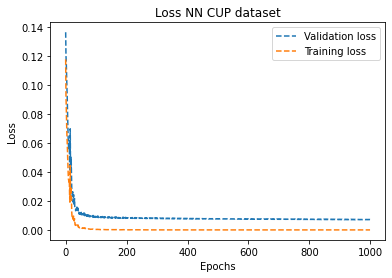

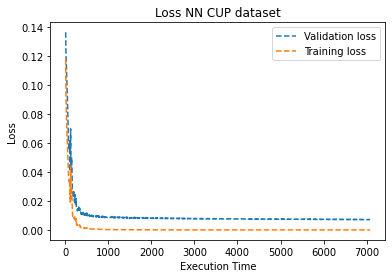

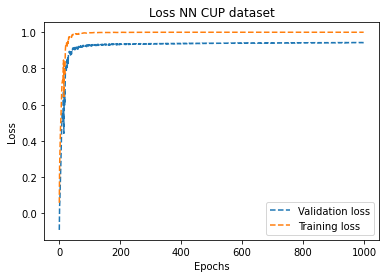

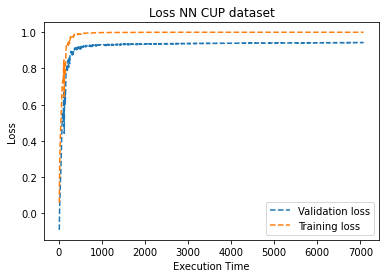

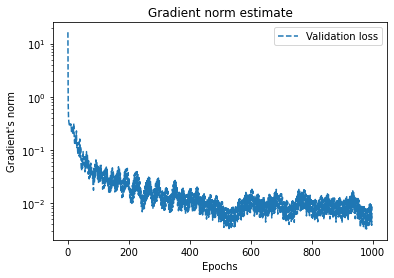

ep: 1000    | s: [] | b: 32 | e:  0.1 | lmbda:0.001 | m:  0.0
Grad: 1.45992e-02 | Loss: 7.06837e-03, 5.76912e-06 | Score: 0.943, 1    
ended in: 7078.812, avg per ep: 7.078812
total update: 4.553, avg updt: 0.004553
total ff: 6000, total ff time: 1979.7779999999946, avg ff: 0.3299629999999991
total bp: 4000, total bp time: 2279.465999999997, avg bp: 0.5698664999999993
total ev: 1000, total ev time: 3048.507999999999, avg ev: 3.048507999999999




<Figure size 432x288 with 0 Axes>

In [10]:
plot_MONK_stats(params, "cup", "SGM", X_train, y_train, X_test, y_test)